# ALS applications

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [2]:
file_path = "zen_item_to_name.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "farantaimoorbutt/zen-dataseet",  
  file_path
)

/tmp/ipykernel_31/1714063509.py:4: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


## Dzen dataset

Data comes from [dzen.ru](https://dzen.ru/) site and consists of likes which users put to text articles

### Columns
1. item_id - unique id of an item (article)
2. user_id - unique id of a user
3. source_id - unique id of an author. If two items have same source_id, then they come from one author
4. Name of item is name of the article
5. Raw dataset represents user_id and list of item_ids which user liked

In [1]:
!curl -O -J -L 'https://www.dropbox.com/s/ia4bvhuqg8kesee/zen_dataset.zip?dl=1'
!unzip zen_dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   132  100   132    0     0    645      0 --:--:-- --:--:-- --:--:--   647
100    17  100    17    0     0     31      0 --:--:-- --:--:-- --:--:--    31
100   496    0   496    0     0    420      0 --:--:--  0:00:01 --:--:--   813
100 24.0M  100 24.0M    0     0  11.9M      0  0:00:02  0:00:02 --:--:-- 54.8M
unzip:  cannot find or open zen_dataset.zip, zen_dataset.zip.zip or zen_dataset.zip.ZIP.


In [87]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from tqdm.notebook import tqdm
import ast
import torch
import time
import matplotlib.pyplot as plt
from scipy import sparse

In [5]:
gpu = torch.device('cuda')
gpu

device(type='cuda')

In [6]:
item_names =  kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,"farantaimoorbutt/zen-dataseet",'zen_item_to_name.csv')
item_sources = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,"farantaimoorbutt/zen-dataseet",'zen_item_to_source.csv')
dataset = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,"farantaimoorbutt/zen-dataseet",'zen_ratings.csv')

/tmp/ipykernel_31/933663810.py:1: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  item_names =  kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,"farantaimoorbutt/zen-dataseet",'zen_item_to_name.csv')
/tmp/ipykernel_31/933663810.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  item_sources = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,"farantaimoorbutt/zen-dataseet",'zen_item_to_source.csv')
/tmp/ipykernel_31/933663810.py:3: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  dataset = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,"farantaimoorbutt/zen-dataseet",'zen_ratings.csv')


In [7]:

dataset = dataset[:5000]
dataset['item_ids'] = dataset['item_ids'].apply(ast.literal_eval)
dataset.head()

,user_id,item_ids
0,993675863667353526,"[15267, 61075, 81203, 17066, 25471, 88427, 638..."
1,4250619547882954185,"[4555, 94644, 84972, 17774, 94962, 78217, 2485..."
2,3847785305345691076,"[1898, 26703, 16525, 86939, 55017, 31069, 4035..."
3,1785181112918558233,"[75601, 102458, 28716, 100694, 5757, 47104, 60..."
4,5078748097863903181,"[72260, 40825, 2615, 42549, 379, 100818, 56827..."


In [8]:
item_names

,id,name
0,94962,Что обычно ожидало русских казачек в руках у к...
1,3972,Почему Россия решила строить новую скоростную ...
2,94644,"5 неприличных фактов об Андрее Макаревиче, кот..."
3,82518,"Что стало с красавицей Хмельницкой, которую му..."
4,53264,"Понять и Простить: Почему угонщики, бежавшие и..."
...,...,...
104498,36769,"Плюс один источник мифа о рыцарях, неспособных..."
104499,9190,Мой сад - малоуходный
104500,52731,Купил первую в жизни циркулярную пилу. Честный...
104501,72660,Решили предложить Марине помощь в лечении ч.10


In [9]:
item_sources

,id,source
0,94962,2919814402697966089
1,3972,3263022753228392991
2,94644,-3857390427602554682
3,82518,-9036908390349249792
4,53264,3353856219169766284
...,...,...
104498,36769,3818746211375738614
104499,9190,4975535765688979937
104500,52731,3720366796439288909
104501,72660,-7860042973720636310


In [10]:
dataset

,user_id,item_ids
0,993675863667353526,"[15267, 61075, 81203, 17066, 25471, 88427, 638..."
1,4250619547882954185,"[4555, 94644, 84972, 17774, 94962, 78217, 2485..."
2,3847785305345691076,"[1898, 26703, 16525, 86939, 55017, 31069, 4035..."
3,1785181112918558233,"[75601, 102458, 28716, 100694, 5757, 47104, 60..."
4,5078748097863903181,"[72260, 40825, 2615, 42549, 379, 100818, 56827..."
...,...,...
4995,1783247335571225144,"[58649, 40423, 8706, 80540, 48042, 6527, 82238..."
4996,435401615695014005,"[96085, 16607, 100349, 104327, 86713, 99974, 5..."
4997,2324486976962366344,"[54393, 1527, 38651, 38488, 93694, 54932, 5925..."
4998,1084392302990541991,"[54372, 93575, 9661, 69953, 73912, 44480, 1566..."


In [11]:
total_interactions_count = dataset.item_ids.map(len).sum()

user_coo = np.zeros(total_interactions_count, dtype=np.int64)
item_coo = np.zeros(total_interactions_count, dtype=np.int64)

pos = 0
for user_id, item_ids in enumerate(tqdm(dataset.item_ids)):
    user_coo[pos : pos + len(item_ids)] = user_id
    item_coo[pos : pos + len(item_ids)] = item_ids
    pos += len(item_ids)

shape = (max(user_coo) + 1, max(item_coo) + 1)
user_item_matrix = sp.coo_matrix(
    (np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape
).tocsr()

# Save for reuse
sp.save_npz("data_train.npz", user_item_matrix)

# Cleanup memory
del user_coo
del item_coo
del dataset


  0%|          | 0/5000 [00:00<?, ?it/s]

In [12]:
# you could start here if you already done precomputing
user_item_matrix = sp.load_npz("data_train.npz")

In [13]:
user_item_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 378009 stored elements and shape (5000, 104503)>

In [14]:
def sparce_matrix_report(matrix):
    print('Size of raw data:', matrix.data.nbytes / 10**6, 'Mb')
    print('Feedback matrix size:', matrix.shape)

In [15]:
sparce_matrix_report(user_item_matrix)

Size of raw data: 3.024072 Mb
Feedback matrix size: (5000, 104503)


In [16]:
item_weights = np.array(user_item_matrix.tocsc().sum(0))[0]
top_to_bottom_order = np.argsort(-item_weights)
item_mapping = np.empty(top_to_bottom_order.shape, dtype=int)
item_mapping[top_to_bottom_order] = np.arange(len(top_to_bottom_order))
total_item_count = (item_weights > 0).sum()
total_user_count = user_item_matrix.shape[0]


def build_debug_dataset(user_item_matrix, item_pct: float, user_pct: float):
    '''Get given percent of top rated items and given percent of random users'''
    user_count = int(total_user_count * user_pct),
    item_count = int(total_item_count * item_pct)
    item_ids = top_to_bottom_order[:item_count]
    user_ids = np.random.choice(
        np.arange(user_item_matrix.shape[0]), size=user_count, replace=False
    )
    train = user_item_matrix[user_ids]
    train = train[:, item_ids]
    return train


In [17]:
debug_dataset = build_debug_dataset(user_item_matrix, 0.1, 0.1)

sparce_matrix_report(debug_dataset)

Size of raw data: 0.160144 Mb
Feedback matrix size: (500, 6445)


This is useful for debugging (just to save time).

**Final answers should use full dataset!!!**

## Split dataset matrix (5 points)

in the following way: for 20% of users (random) remove one like - this will be test data. The rest is train data.

In [18]:
def split_data(user_item_matrix, test_user_pct=0.2, seed=42):
    np.random.seed(seed)
    all_users = np.arange(user_item_matrix.shape[0])
    test_users = np.random.choice(all_users, size=int(len(all_users) * test_user_pct), replace=False)
    train_matrix = user_item_matrix.copy()
    test_matrix = sp.lil_matrix(user_item_matrix.shape, dtype=np.float32) 
    for user in tqdm(test_users, desc="Splitting interactions"):
        user_likes = user_item_matrix[user].nonzero()[1]
        
        if len(user_likes) == 0:
            continue
        test_item = np.random.choice(user_likes)
        train_matrix[user, test_item] = 0
        test_matrix[user, test_item] = 1.0
    train_matrix.eliminate_zeros()
    test_matrix = test_matrix.tocsr()

    return train_matrix, test_matrix


In [20]:
train_ratings, test_ratings = split_data(user_item_matrix)

Splitting interactions:   0%|          | 0/1000 [00:00<?, ?it/s]

# ALS

In [21]:
class ALS:
    def __init__(self, train_matrix, test_matrix=None, device='cuda'):
        self.train_matrix = train_matrix
        self.test_matrix = test_matrix
        self.device = device if torch.cuda.is_available() else 'cpu'

        self.num_users, self.num_items = train_matrix.shape

    def train(self, k=96, lam=0.1, iterations=15):
        self.k = k
        self.lam = lam
        self.user_embeddings = torch.randn(self.num_users, k, device=self.device) * 0.01
        self.item_embeddings = torch.randn(self.num_items, k, device=self.device) * 0.01
        self.train_matrix_csr = self.train_matrix.tocsr()
        self.train_matrix_csc = self.train_matrix.tocsc()
        loss_values = []
        print("Start ALS")
        for it in range(1, iterations + 1):
            start_time = time.time()

            self._update_user_embeddings()
            self._update_item_embeddings()

            mse = self._compute_mse()
            loss_values.append(mse)

            elapsed = time.time() - start_time
            print(f"[Iteration {it}/{iterations}] MSE: {mse:.5f} | Time: {elapsed:.2f}s")

        print("ALS finished")
        return self.user_embeddings, self.item_embeddings, loss_values

    def _update_user_embeddings(self):
        I = torch.eye(self.k, device=self.device)
        Y = self.item_embeddings

        for user in range(self.num_users):
            start, end = self.train_matrix_csr.indptr[user], self.train_matrix_csr.indptr[user+1]
            item_ids = self.train_matrix_csr.indices[start:end]

            if len(item_ids) == 0:
                continue

            Y_u = Y[item_ids]
            A = Y_u.t() @ Y_u + self.lam * len(item_ids) * I
            b = Y_u.sum(0)

            self.user_embeddings[user] = torch.linalg.solve(A, b)
    def _update_item_embeddings(self):
        I = torch.eye(self.k, device=self.device)
        X = self.user_embeddings

        for item in range(self.num_items):
            start, end = self.train_matrix_csc.indptr[item], self.train_matrix_csc.indptr[item+1]
            user_ids = self.train_matrix_csc.indices[start:end]

            if len(user_ids) == 0:
                continue

            X_i = X[user_ids]
            A = X_i.t() @ X_i + self.lam * len(user_ids) * I
            b = X_i.sum(0)

            self.item_embeddings[item] = torch.linalg.solve(A, b)
    def _compute_mse(self):
        X = self.user_embeddings
        Y = self.item_embeddings
        mse = 0
        count = 0

        if self.test_matrix is None:
            return 0.0

        test_csr = self.test_matrix.tocsr()

        for user in range(test_csr.shape[0]):
            start, end = test_csr.indptr[user], test_csr.indptr[user+1]
            item_ids = test_csr.indices[start:end]

            if len(item_ids) == 0:
                continue

            preds = (X[user] @ Y[item_ids].T).detach().cpu().numpy()
            mse += np.sum((preds - 1) ** 2)
            count += len(item_ids)

        return mse / max(count, 1)

In [22]:
als = ALS(train_ratings, test_ratings)

k = 96
lam = 0.1
iterations = 10

user_embeddings, item_embeddings, loss_values = als.train(k, lam, iterations)


Start ALS
[Iteration 1/10] MSE: 0.99350 | Time: 28.82s
[Iteration 2/10] MSE: 0.19583 | Time: 28.26s
[Iteration 3/10] MSE: 0.08645 | Time: 28.23s
[Iteration 4/10] MSE: 0.06741 | Time: 28.24s
[Iteration 5/10] MSE: 0.06333 | Time: 28.28s
[Iteration 6/10] MSE: 0.06219 | Time: 28.15s
[Iteration 7/10] MSE: 0.06180 | Time: 28.28s
[Iteration 8/10] MSE: 0.06163 | Time: 28.25s
[Iteration 9/10] MSE: 0.06156 | Time: 28.18s
[Iteration 10/10] MSE: 0.06152 | Time: 28.15s
ALS finished


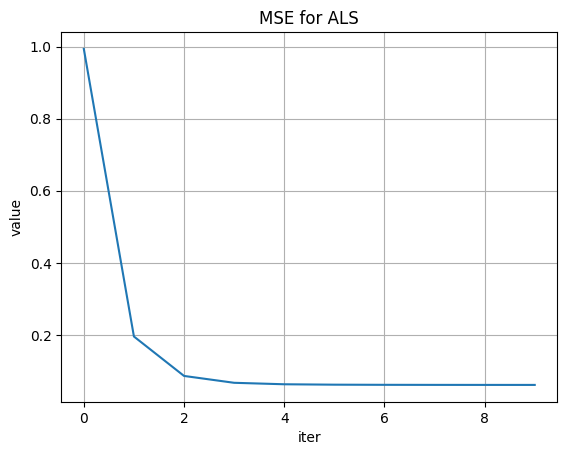

In [24]:
plt.plot(loss_values)
plt.title("MSE for ALS")
plt.xlabel("iter")
plt.ylabel("value")
plt.grid()
plt.show()

## Implement IALS (10 points each)

Note that due to size of data you need to implement algorithm with _sparce matrices_!

You are welcome to use classes like on the seminar:)

In [25]:
class IALS:
    def __init__(self, train_matrix, test_matrix=None, device='cuda'):
        self.train_matrix = train_matrix
        self.test_matrix = test_matrix
        self.device = device if torch.cuda.is_available() else 'cpu'

        self.num_users, self.num_items = train_matrix.shape

    def train(self, k=96, lam=0.1, iterations=15, alpha=40):
        self.k = k
        self.lam = lam
        self.alpha = alpha
        self.user_embeddings = torch.randn(self.num_users, k, device=self.device) * 0.01
        self.item_embeddings = torch.randn(self.num_items, k, device=self.device) * 0.01
        self.train_csr = self.train_matrix.tocsr()
        self.train_csc = self.train_matrix.tocsc()

        loss_values = []

        print("IALS start")
        for it in range(1, iterations + 1):
            start_time = time.time()

            self._update_user_embeddings()
            self._update_item_embeddings()

            mse = self._compute_mse()
            loss_values.append(mse)

            elapsed = time.time() - start_time
            print(f"[Iteration {it}/{iterations}] MSE: {mse:.5f} | Time: {elapsed:.2f}s")

        print("IALS end finally")
        return self.user_embeddings, self.item_embeddings, loss_values

    def _update_user_embeddings(self):
        I = torch.eye(self.k, device=self.device)
        Y = self.item_embeddings

        for user in range(self.num_users):
            start, end = self.train_csr.indptr[user], self.train_csr.indptr[user+1]
            item_ids = self.train_csr.indices[start:end]

            if len(item_ids) == 0:
                continue

            Y_u = Y[item_ids]
            confidence = 1 + self.alpha * torch.ones(len(item_ids), device=self.device)

            A = (Y_u.t() * confidence) @ Y_u + self.lam * I
            b = (confidence @ Y_u)

            self.user_embeddings[user] = torch.linalg.solve(A, b)

    def _update_item_embeddings(self):
        I = torch.eye(self.k, device=self.device)
        X = self.user_embeddings

        for item in range(self.num_items):
            start, end = self.train_csc.indptr[item], self.train_csc.indptr[item+1]
            user_ids = self.train_csc.indices[start:end]

            if len(user_ids) == 0:
                continue

            X_i = X[user_ids]
            confidence = 1 + self.alpha * torch.ones(len(user_ids), device=self.device)

            A = (X_i.t() * confidence) @ X_i + self.lam * I
            b = (confidence @ X_i)

            self.item_embeddings[item] = torch.linalg.solve(A, b)

    def _compute_mse(self):
        X = self.user_embeddings
        Y = self.item_embeddings
        mse = 0
        count = 0

        if self.test_matrix is None:
            return 0.0

        test_csr = self.test_matrix.tocsr()

        for user in range(test_csr.shape[0]):
            start, end = test_csr.indptr[user], test_csr.indptr[user+1]
            item_ids = test_csr.indices[start:end]

            if len(item_ids) == 0:
                continue

            preds = (X[user] @ Y[item_ids].T).detach().cpu().numpy()
            mse += np.sum((preds - 1) ** 2)
            count += len(item_ids)

        return mse / max(count, 1)

In [26]:
ials = IALS(train_ratings, test_ratings)

k = 96
lam = 1 
iterations = 10
alpha = 0.1
ials_user_embeddings, ials_item_embeddings, ials_loss_values = ials.train(k, lam, iterations)

IALS start
[Iteration 1/10] MSE: 1.12019 | Time: 33.42s
[Iteration 2/10] MSE: 0.49185 | Time: 33.26s
[Iteration 3/10] MSE: 0.29662 | Time: 33.26s
[Iteration 4/10] MSE: 0.20638 | Time: 33.21s
[Iteration 5/10] MSE: 0.16538 | Time: 33.25s
[Iteration 6/10] MSE: 0.14506 | Time: 33.32s
[Iteration 7/10] MSE: 0.13497 | Time: 33.22s
[Iteration 8/10] MSE: 0.13070 | Time: 33.28s
[Iteration 9/10] MSE: 0.12912 | Time: 33.24s
[Iteration 10/10] MSE: 0.12879 | Time: 33.30s
IALS end finally


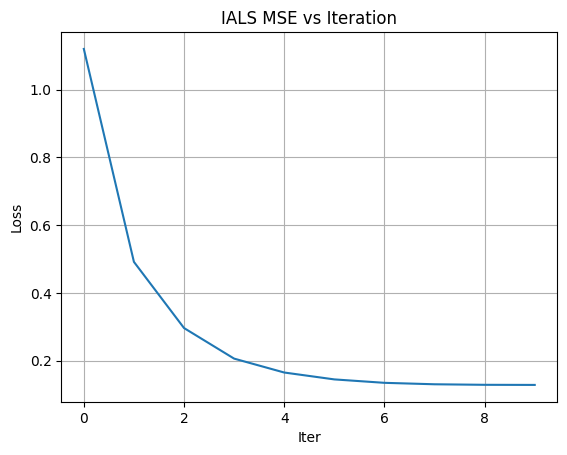

In [27]:
plt.plot(ials_loss_values)
plt.title("IALS MSE vs Iteration")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.grid()
plt.show()


## Compute MRR@100 metric for test users

For ALS and IALS algorithms.

**Don't forget to use full dataset!**

In [28]:
def compute_mrr_at_100(user_embeddings, item_embeddings, train_matrix, test_matrix, device='cuda'):
    user_embeddings = user_embeddings.to(device)
    item_embeddings = item_embeddings.to(device)

    mrrs = []
    test_csr = test_matrix.tocsr()
    train_csr = train_matrix.tocsr()

    for user in range(user_embeddings.shape[0]):
        start, end = test_csr.indptr[user], test_csr.indptr[user+1]
        true_items = test_csr.indices[start:end]
        if len(true_items) == 0:
            continue 
        scores = torch.matmul(user_embeddings[user], item_embeddings.T)
        train_items = train_csr.indices[train_csr.indptr[user]:train_csr.indptr[user+1]]
        scores[train_items] = -float('inf')
        topk_indices = torch.topk(scores, 100).indices.cpu().numpy()
        rank = None
        for idx, item in enumerate(topk_indices, start=1):
            if item in true_items:
                rank = idx
                break

        if rank is not None:
            mrrs.append(1 / rank)
        else:
            mrrs.append(0)

    return np.mean(mrrs)

In [29]:
mrr_als = compute_mrr_at_100(user_embeddings, item_embeddings, train_ratings, test_ratings)
print(f"ALS MRR@100: {mrr_als:.5f}")

ALS MRR@100: 0.00061


In [30]:
mrr_ials = compute_mrr_at_100(ials_user_embeddings, ials_item_embeddings, train_ratings, test_ratings)
print(f"IALS MRR@100: {mrr_ials:.5f}")

IALS MRR@100: 0.00159


## Adjust hyperparameters of IALS to maximize MRR (10 points)

Main hyperparameters are regularization and weights for implicit case.

In [33]:
def tune_hyperparameters(train_matrix, test_matrix, algorithm='ALS', k=96, iterations=15):
    regularization_values = [0.01, 0.05, 0.1, 0.5, 1.0]
    alpha_values = [0.1, 0.5, 1.0, 2.0] if algorithm == 'IALS' else [None]  
    best_mrr = -1
    best_lam = None
    best_alpha = None
    best_user_embeddings = None
    best_item_embeddings = None
    for lam in regularization_values:
        for alpha in alpha_values:
            print(f"Tuning: {algorithm}, lam={lam}, alpha={alpha}")
            if algorithm == 'IALS':
                model = IALS(train_matrix, test_matrix)
              
                user_embeddings, item_embeddings, _ = model.train(k=k, lam=lam, iterations=iterations, alpha=alpha)
            else: 
                model = ALS(train_matrix, test_matrix)
                user_embeddings, item_embeddings, _ = model.train(k=k, lam=lam, iterations=iterations)
 
            mrr = compute_mrr_at_100(user_embeddings, item_embeddings, train_matrix, test_matrix)
            print(f"MRR@100: {mrr:.5f}")
            if mrr > best_mrr:
                best_mrr = mrr
                best_lam = lam
                best_alpha = alpha if algorithm == 'IALS' else None
                best_user_embeddings = user_embeddings
                best_item_embeddings = item_embeddings
    
    return best_lam, best_alpha, best_user_embeddings, best_item_embeddings,best_mrr


In [34]:
best_lam_ials, best_alpha_ials, best_user_embeddings_ials, best_item_embeddings_ials, best_mrr = tune_hyperparameters(
    train_matrix=train_ratings, test_matrix=test_ratings, algorithm='IALS', k=96, iterations=5
)

print("\n best hyperparameter:")
print(f"Algorithm: IALS")
print(f"Regularization (lam): {best_lam_ials}")
print(f"Implicit Feedback Weight (alpha): {best_alpha_ials}")
print(f"Best MRR@100: {best_mrr:.5f}")

Tuning: IALS, lam=0.01, alpha=0.1
IALS start
[Iteration 1/5] MSE: 1.35109 | Time: 33.45s
[Iteration 2/5] MSE: 0.53018 | Time: 33.42s
[Iteration 3/5] MSE: 0.28004 | Time: 33.32s
[Iteration 4/5] MSE: 0.19373 | Time: 33.25s
[Iteration 5/5] MSE: 0.15743 | Time: 33.25s
IALS end finally
MRR@100: 0.00128
Tuning: IALS, lam=0.01, alpha=0.5
IALS start
[Iteration 1/5] MSE: 1.17561 | Time: 33.27s
[Iteration 2/5] MSE: 0.56261 | Time: 33.27s
[Iteration 3/5] MSE: 0.31325 | Time: 33.29s
[Iteration 4/5] MSE: 0.20976 | Time: 33.32s
[Iteration 5/5] MSE: 0.16972 | Time: 33.36s
IALS end finally
MRR@100: 0.00223
Tuning: IALS, lam=0.01, alpha=1.0
IALS start
[Iteration 1/5] MSE: 1.13541 | Time: 33.22s
[Iteration 2/5] MSE: 0.49595 | Time: 33.32s
[Iteration 3/5] MSE: 0.28949 | Time: 33.29s
[Iteration 4/5] MSE: 0.20524 | Time: 33.31s
[Iteration 5/5] MSE: 0.16539 | Time: 33.33s
IALS end finally
MRR@100: 0.00292
Tuning: IALS, lam=0.01, alpha=2.0
IALS start
[Iteration 1/5] MSE: 1.24604 | Time: 33.32s
[Iteration 2/5


Optimal parameters of IALS are:

1. Regularization (lam): 1.0
2. Implicit Feedback Weight (alpha): 0.1
3. Best MRR@100: 0.00756

## Get similarities from item2item CF (10 points)

Item2item can be taken from the first homework, SLIM was implemented in the class.

Alternatively you could use libraries, but in this case you will need to convert dataset to their format.

You need to compute only item similarities, not predictions for users.
You need to implement 4 similarity functions:

Dot product (intersection)
Jaccard index (intersection over union)
Pearson correlation
Pearson correlation with decreasing coefficient

In [ ]:
def compute_item_similarities(user_item_matrix, similarity_type='cosine', top_k, batch_size=500):
    ui_csc = user_item_matrix.tocsc()
    num_items = ui_csc.shape[1]
    if similarity_type in ('cosine', 'pearson'):
        item_sumsq = np.array(ui_csc.power(2).sum(axis=0)).ravel()
        norms = np.sqrt(item_sumsq)
        norms[norms == 0] = 1e-8
        
    if similarity_type == 'jaccard':
        bin_csc = ui_csc.copy()
        bin_csc.data[:] = 1
        item_counts = np.array(bin_csc.sum(axis=0)).ravel()
    rows, cols, vals = [], [], []
    for start in tqdm(range(0, num_items, batch_size), desc=f"{similarity_type} computed"):
        end = min(start + batch_size, num_items)
        batch_idx = np.arange(start, end)
        batch = ui_csc[:, batch_idx].transpose(copy=False)

        if similarity_type == 'cosine':
            batch_norm = batch.multiply(1.0 / norms[batch_idx][:, None])
            full_norm = ui_csc.multiply(1.0 / norms)
            sim_block = batch_norm.dot(full_norm)
        elif similarity_type == 'jaccard':
            batch_bin = bin_csc[:, batch_idx].transpose(copy=False)
            inter = batch_bin.dot(bin_csc)
            batch_count = np.array(batch_bin.sum(axis=1)).ravel()[:, None]
            union = batch_count + item_counts[None, :] - inter.toarray()
            sim_block = sparse.csr_matrix(inter.multiply(1.0) / (union + 1e-8))

        elif similarity_type == 'pearson':
            means = np.array(batch.mean(axis=1)).ravel()
            batch_center = batch.copy().astype(float)
            for i_row, m in enumerate(means):
                if m != 0:
                    batch_center[i_row].data -= m
            full_means = np.array(ui_csc.mean(axis=0)).ravel()
            full_center = ui_csc.copy().astype(float)
            for i_col, m in enumerate(full_means):
                if m != 0:
                    full_center[:, i_col].data -= m
            block_norms = np.sqrt(np.array(batch_center.power(2).sum(axis=1))).ravel()
            full_norms = np.sqrt(np.array(full_center.power(2).sum(axis=0))).ravel()
            block_norms[block_norms == 0] = 1e-8
            full_norms[full_norms == 0] = 1e-8
            batch_norm = batch_center.multiply(1.0 / block_norms[:, None])
            full_norm = full_center.multiply(1.0 / full_norms)
            sim_block = batch_norm.dot(full_norm)

        else:
            raise ValueError(f"unknown similarity func: {similarity_type}")
        block = sim_block.tocoo()
        for r, c, v in zip(block.row, block.col, block.data):
            if r != c and v > 0:
                rows.append(start + r)
                cols.append(c)
                vals.append(v)

    sim_matrix = sparse.coo_matrix((vals, (rows, cols)), shape=(num_items, num_items)).tocsr()
    return sim_matrix

In [ ]:
cosine_sim  = compute_item_similarities(user_item_matrix, 'cosine',top_k=50)
jaccard_sim = compute_item_similarities(user_item_matrix, 'jaccard',top_k=50)

## Compare similarities from four algorithms (20 points)

* plot distributions
* compute metrics (which you think are relevant)
* look at several top similar lists

Make conclusion how these methods differ in computing similarities

In [88]:
def plot_similarity_distributions(sims, labels, bins=100):
    plt.figure(figsize=(10,6))
    for sim, label in zip(sims, labels):
        plt.hist(sim.data, bins=bins, alpha=0.5, label=label, density=True)
    plt.xlabel('Similarity Score')
    plt.ylabel('Density')
    plt.title('Similarity Score Distributions')
    plt.legend()
    plt.grid(True)
    plt.show()

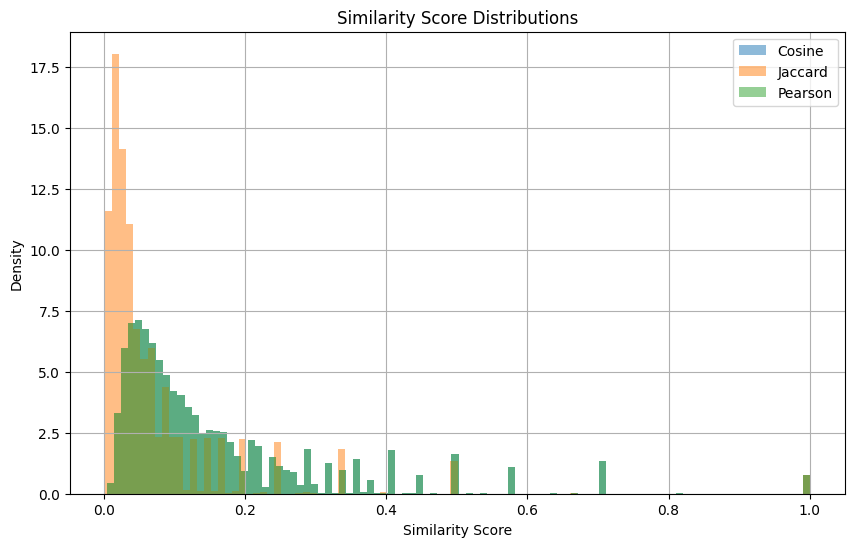

In [89]:
labels = ['Cosine', 'Jaccard', 'Pearson']
plot_similarity_distributions(
    [cosine_sim, jaccard_sim, pearson_sim], labels
)

In [90]:
def compute_similarity_metrics(sim_matrix):
    vals = sim_matrix.data
    total = sim_matrix.shape[0] * sim_matrix.shape[1]
    return {
        'mean': vals.mean(),
        'std': vals.std(),
        'min': vals.min(),
        'max': vals.max(),
        'sparsity': 1 - len(vals)/total
    }


# Metrics

In [91]:
metrics = {lbl: compute_similarity_metrics(sim)
           for lbl, sim in zip(labels, [cosine_sim, jaccard_sim, pearson_sim,])}
print("\nSimilarity mtrics")
for lbl, met in metrics.items():
    print(f"{lbl}: {met}")


Similarity mtrics
Cosine: {'mean': 0.15353222023015434, 'std': 0.15318802181056737, 'min': 0.004943473238901381, 'max': 1.0000000000000069, 'sparsity': 0.9956501566714054}
Jaccard: {'mean': 0.07433981239543391, 'std': 0.11654923081783872, 'min': 0.002164502164455314, 'max': 0.9999999999744245, 'sparsity': 0.9956501566714054}
Pearson: {'mean': 0.15353222023015434, 'std': 0.15318802181056737, 'min': 0.004943473238901381, 'max': 1.0000000000000069, 'sparsity': 0.9956501566714054}


# Cosine Similar Items

In [100]:
show_top_similar_items_with_names(cosine_sim, sample_items, top_to_bottom_order, item_names)

Item 0 (Original ID 94962) - Что обычно ожидало русских казачек в руках у кавказских горцев. Рассказываем top-5 similar items:
 -> Item 93250 (Original ID 18152) - Решите пример! with similarity 1.0000
 -> Item 102201 (Original ID 3865) - Заставлять или договариваться. Как вести себя с аутичным ребенком. with similarity 1.0000
 -> Item 60672 (Original ID 32525) - Как я делал прививку от коронавируса with similarity 1.0000
 -> Item 90373 (Original ID 22763) - Как мы проехали на машине от Москвы до Владивостока и потратили 243 тысячи рублей за 2,5 месяца with similarity 0.7071
 -> Item 76985 (Original ID 44419) - Записки бобров из Москвы - младшие приболели, новости Жу и про сборы with similarity 0.7071
--------------------------------------------------
Item 1 (Original ID 3972) - Почему Россия решила строить новую скоростную дорогу в Китай в обход дружественного Казахстана top-5 similar items:
 -> Item 89215 (Original ID 89193) - Знакомство в клубе (рассказ). Часть 10. with similarity 0

# Jaccard Similar Items

In [94]:
show_top_similar_items_with_names(jaccard_sim, sample_items, top_to_bottom_order, item_names)

Jaccard Similar Item
Item 0 (Original ID 94962) - Что обычно ожидало русских казачек в руках у кавказских горцев. Рассказываем top-5 similar items:
 -> Item 93250 (Original ID 18152) - Решите пример! with similarity 1.0000
 -> Item 102201 (Original ID 3865) - Заставлять или договариваться. Как вести себя с аутичным ребенком. with similarity 1.0000
 -> Item 60672 (Original ID 32525) - Как я делал прививку от коронавируса with similarity 1.0000
 -> Item 90373 (Original ID 22763) - Как мы проехали на машине от Москвы до Владивостока и потратили 243 тысячи рублей за 2,5 месяца with similarity 0.5000
 -> Item 76985 (Original ID 44419) - Записки бобров из Москвы - младшие приболели, новости Жу и про сборы with similarity 0.5000
--------------------------------------------------
Item 1 (Original ID 3972) - Почему Россия решила строить новую скоростную дорогу в Китай в обход дружественного Казахстана top-5 similar items:
 -> Item 34944 (Original ID 34988) - Что сделать, чтобы не перегибался шл

# Pearson Similar Items

In [96]:
show_top_similar_items_with_names(pearson_sim, sample_items, top_to_bottom_order, item_names)

Peason Similar Item 

Item 0 (Original ID 94962) - Что обычно ожидало русских казачек в руках у кавказских горцев. Рассказываем top-5 similar items:
 -> Item 93250 (Original ID 18152) - Решите пример! with similarity 1.0000
 -> Item 102201 (Original ID 3865) - Заставлять или договариваться. Как вести себя с аутичным ребенком. with similarity 1.0000
 -> Item 60672 (Original ID 32525) - Как я делал прививку от коронавируса with similarity 1.0000
 -> Item 90373 (Original ID 22763) - Как мы проехали на машине от Москвы до Владивостока и потратили 243 тысячи рублей за 2,5 месяца with similarity 0.7071
 -> Item 76985 (Original ID 44419) - Записки бобров из Москвы - младшие приболели, новости Жу и про сборы with similarity 0.7071
--------------------------------------------------
Item 1 (Original ID 3972) - Почему Россия решила строить новую скоростную дорогу в Китай в обход дружественного Казахстана top-5 similar items:
 -> Item 89215 (Original ID 89193) - Знакомство в клубе (рассказ). Часть

Conclusion:

Cosine and Pearson are very close statistically

Cosine and Pearson provide meaningful item

Jaccard is almost uninformative here and Jaccard is not a good fit here.Jaccard is producing the most extreme results ( 0 or 1)

For recommending similar items based on dense representations, Cosine or Pearson similarity is clearly better.